# Frequency grid analysis for periodogram: how to choose the proper grid, trade-offs and its cost

Ignacio Reyes Jainaga
Last modification: 20241018

In [1]:
import numpy as np
import matplotlib.pyplot as plt

* To find the period of a light curve we need to fold it using many candidate periods. The list of those candidate periods is called *period grid*.
* If the grid is too coarse, there is a risk of missing the right candidate period. In a coarse grid, the right period might end up in between two candidates and neither of them providing a good fold.
* If the grid is too fine, the computational cost goes up.
* We would like to have a grid with the same "sensitivity" for any true period in the search range. An equally-spaced frequency grid offers that property.
* In the next block we will show that property experimentally.

## Example

Two light curves. Both of them span 6 years, with an average cadence of one observation every 5 days.
Light curve 1 has a 0.3 day period, light curve 2 has a 9.4 day period.

In [2]:
timespan = 6 * 365  # days
average_cadence = 1 / 5  # observations per day

n_obs = int(timespan * average_cadence)
times = np.random.rand(n_obs) * timespan
times = np.sort(times)
errors = 0.2 * np.ones(n_obs)

In [3]:
period_1 = 0.3  # days
magnitudes_1 = np.sin(2*np.pi*(1/period_1)*times) + errors * np.random.randn(n_obs)

In [4]:
period_2 = 9.4  # days
magnitudes_2 = np.sin(2*np.pi*(1/period_2)*times) + errors * np.random.randn(n_obs)

In [5]:
smallest_frequency = 1.0/100
largest_frequency = 1.0/0.05
f_range = largest_frequency - smallest_frequency
shift = 0.15
grid_size = int(np.ceil(f_range * timespan / (2.0 * shift)))
print(grid_size)

145927


In [6]:
dfreq = (largest_frequency - smallest_frequency) / (grid_size - 1)
almost_period_1 = 1/(1/period_1 + dfreq)
almost_period_1, period_1

(0.2999876716550381, 0.3)

In [7]:
dfreq = (largest_frequency - smallest_frequency) / (grid_size - 1)
almost_period_2 = 1/(1/period_2 + dfreq)
almost_period_2, period_2

(9.387911373747, 9.4)

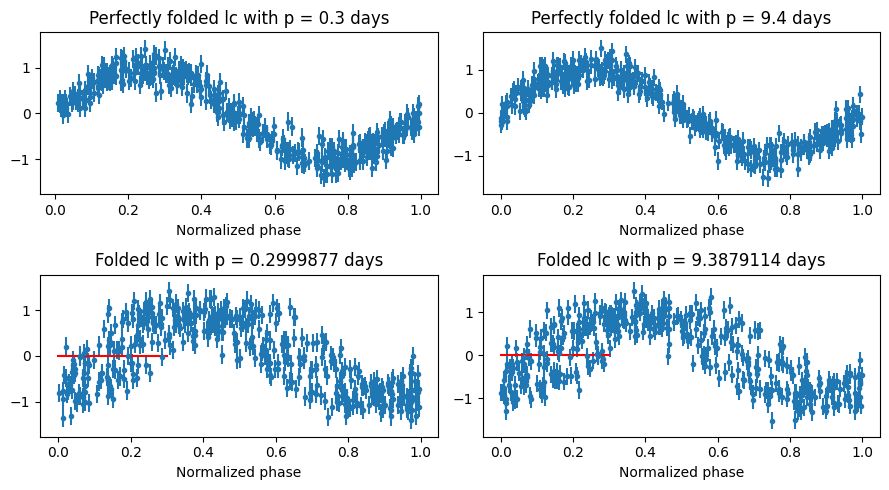

In [8]:
plt.figure(figsize=(9, 5))

plt.subplot(2, 2, 1)
plt.errorbar(
    (times % period_1)/period_1, 
    magnitudes_1,
    yerr=errors,
    fmt='.'
)
plt.title(f'Perfectly folded lc with p = {period_1} days')
plt.xlabel('Normalized phase')

plt.subplot(2, 2, 2)
plt.errorbar(
    (times % period_2)/period_2,
    magnitudes_2,
    yerr=errors,
    fmt='.'
)
plt.title(f'Perfectly folded lc with p = {period_2} days')
plt.xlabel('Normalized phase')
plt.subplot(2, 2, 3)
plt.errorbar(
    (times % almost_period_1)/almost_period_1, 
    magnitudes_1,
    yerr=errors,
    fmt='.'
)
plt.plot((0, 2*shift), (0, 0), c='r')
plt.title(f'Folded lc with p = {almost_period_1:.7f} days')
plt.xlabel('Normalized phase')
plt.subplot(2, 2, 4)
plt.errorbar(
    (times % almost_period_2)/almost_period_2,
    magnitudes_2,
    yerr=errors,
    fmt='.'
)
plt.plot((0, 2*shift), (0, 0), c='r')
plt.title(f'Folded lc with p = {almost_period_2:.7f} days')
plt.xlabel('Normalized phase')
plt.tight_layout();

## Optimal grid derivation:

Let's consider a light curve of true period $P$ and composed from many observations $(t_i, x_i),\quad i=1,\dots, N$ and time span $L$.
If a given observation $i$ appears at normalized phase $\theta$ when folded with the true period $P$, the normalized phase when folding with period $P' = P + dP$ will be $$\theta' = \theta + \frac{dP}{P'} \left\lfloor \frac{t_i}{P'} \right\rfloor \approx \theta + \frac{dP}{P} \left\lfloor \frac{t_i}{P} \right\rfloor,$$
so the normalized phase shift is given by

$$\frac{dP}{P} \left\lfloor \frac{t_i}{P} \right\rfloor .$$

Taking the average for all the observations, we get the following expression:

$$\frac{1}{N}\sum_{i=1}^{N} \frac{dP}{P} \left\lfloor \frac{t_i}{P} \right\rfloor \approx \frac{dP}{P} \cdot \frac{L/2}{P} = \frac{dP \cdot L}{2P^2}$$

A period grid is a finite sequence of numbers $p_i,\quad i=1, \dots, M$. As the average normalized phase shift is given by

$$ \phi = \frac{dP \cdot L}{2P^2} $$

and we want this value to be independent of $P$, we need a period grid where the spacings $dP$ are such that $\frac{dP}{P^2}$ is constant for any true period $P$.

For simplicity, and considering that $dP \ll P$, we will solve the problem replacing the discrete sequence $p_i$ by a continuous function $p(i),\quad i \in \mathbb{R}$ and solving a differential equation:

$$ \int \frac{dP\cdot L}{2P^2} = \int c\cdot di,$$

where $c$ is a real positive constant. Solving the equation we end up with

$$ -\frac{L}{2} \left ( \frac{1}{P} + k \right) = c\cdot i + d,$$

where $d$ and $k$ are also integration constants. We can define the frequency $f$ as $f = 1 / P$, which reveals that the relation between frequency and the index $i$ must be linear (affine).

In computational terms, the period grid must have the form:

`frequency_grid = np.linspace(1/largest_period, 1/smallest_period, M)`


`period_grid = 1 / frequency_grid`

Let's define the frequency range of the grid as $$ f_{range} = \frac{1}{smallest\_period} - \frac{1}{largest\_period}.$$

Then, the grid points (in frequency) are

$$f_i = \frac{1}{largest\_period} + f_{range} \cdot \frac{i}{M}.$$

The difference between $f_i$ and $f_{i+1}$ is 

$$ df_i = \frac{f_{range}}{M}$$

and the difference between the corresponding periods is

$$ dp_i = \frac{1}{f_i} - \frac{1}{f_i+df_i} = \frac{df_i}{f_i(f_i+df_i)} = \frac{df_i}{f_i^2}.$$

Replacing $dp_i$ in the expression for $\phi$ we have

$$ \phi = \frac{dp_i \cdot L}{2\cdot p_i^2} = \frac{df_i}{f_i^2}\cdot\frac{L}{2p_i^2} = \frac{df_i \cdot L}{2}$$

and replacing $df_i$ we get

$$ \phi = \frac{df_i \cdot L}{2} = \frac{f_{range} \cdot L}{2\cdot M}.$$

Finally, reordering the terms, we have an expression for $M$:

$$ M = \frac{f_{range}\cdot L}{2\phi}.$$

Remember that $\phi$ is the average dispersion in normalized phase (between 0 and 1), valid when the observation times are uniformly distributed inside the observation time span.
